# Тематическая классификация длинных текстов

сделано на классном курсе Samsung на stepik

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 293, done.
remote: Total 293 (delta 0), reused 0 (delta 0), pack-reused 293
Receiving objects: 100% (293/293), 42.29 MiB | 12.75 MiB/s, done.
Resolving deltas: 100% (134/134), done.
Checking out files: 100% (51/51), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.0 MB/s 
     |████████████████████████████████| 1.7 MB 12.9 MB/s 
     |████████████████████████████████| 23.4 MB 166 kB/s 
     |████████████████████████████████| 304 kB 45.4 MB/s 
     |████████████████████████████████| 8.2 MB 38.2 MB/s 
     |████████████████████████████████| 1.6 MB 42.9 MB/s 
  Created wheel for gensim: filename=gensim-3.8.1-cp38-cp38-linux_x86_64.whl size=25870892 sha256=a01163a495578918f33a7764f3fd2c21a1696c708afec7fb7431db5b9549ca6e
  Stored in directory: /root/.cache/pip/wheels/33/de/03/7346ae70da7f980f78569668caf78fb2d678b176e549557c7d
  

In [2]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

In [3]:
import numpy as np
import scipy.sparse
import torch
from torch.utils.data import Dataset

## Предобработка текстов и подготовка признаков

In [4]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [5]:
import collections
import re

import numpy as np

TOKEN_RE = re.compile(r'[\w\d]+')


def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]


def character_tokenize(txt):
    return list(txt)


def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]


def add_fake_token(word2id, token='<PAD>'):
    word2id_new = {token: i + 1 for token, i in word2id.items()}
    word2id_new[token] = 0
    return word2id_new


def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]


def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


PAD_TOKEN = '__PAD__'
NUMERIC_TOKEN = '__NUMBER__'
NUMERIC_RE = re.compile(r'^([0-9.,e+\-]+|[mcxvi]+)$', re.I)


def replace_number_nokens(tokenized_texts):
    return [[token if not NUMERIC_RE.match(token) else NUMERIC_TOKEN for token in text]
            for text in tokenized_texts]


In [6]:
import numpy as np
import scipy.sparse
import torch
from torch.utils.data import Dataset


def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    assert mode in {'tfidf', 'idf', 'tf', 'bin'}

    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    # получаем бинарные вектора "встречается или нет"
    if mode == 'bin':
        result = (result > 0).astype('float32')

    # получаем вектора относительных частот слова в документе
    elif mode == 'tf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))

    # полностью убираем информацию о количестве употреблений слова в данном документе,
    # но оставляем информацию о частотности слова в корпусе в целом
    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(1 / word2freq)

    # учитываем всю информацию, которая у нас есть:
    # частоту слова в документе и частоту слова в корпусе
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(1 / word2freq)  # разделить каждый столбец на вес слова

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()


class SparseFeaturesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        cur_features = torch.from_numpy(self.features[idx].toarray()[0]).float()
        cur_label = torch.from_numpy(np.asarray(self.targets[idx])).long()
        return cur_features, cur_label

In [7]:
#train_tokenized - разбиение исходного текста на базовые лексические элементы,приведенный к нижнему регистру список списков
# Она принимает на вход список строк


train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [8]:
# строим словарь - vocabulary с помощью функции build_vocabulary
# принимает на вход список списков токенезированные
# word_doc_freq - содержит относительные частоты всех слов в датасете, он понадобиться 
# на этапе формирования матрицы признаков

MAX_DF = 0.8 #во скольких документах встречаеться слово
MIN_COUNT = 5 # сколько раз слово встречаеться в тексте


vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


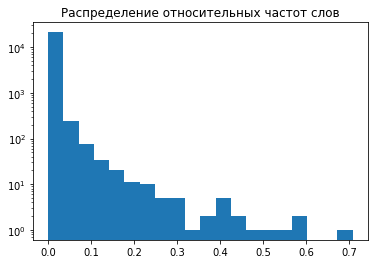

In [10]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [11]:
VECTORIZATION_MODE = 'tfidf'
# построение матрицы признаков по методу мешка слов
# функция vectorize_texts принимает на вход
#1. токенизированные список списков
#2. словарь
#3. вектор частоты токенизированны
#4. алгоритм взвешивания токенов по частоте mode - есть 4 алгорима - bin,tf,idf,tfidf
#5. флаг чтобы перемаштабировать флаг после взвешивания

train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


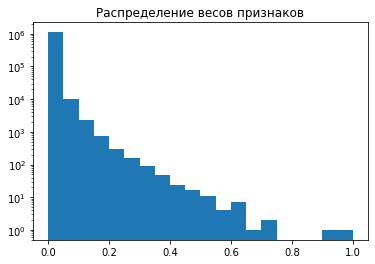

In [12]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [13]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


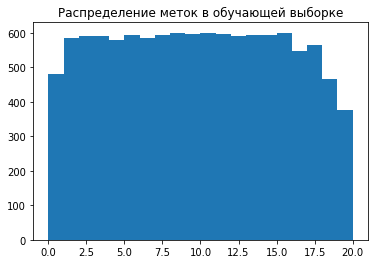

In [14]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

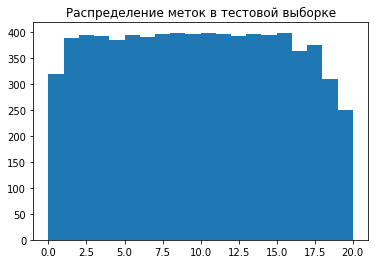

In [15]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

# Обучение

## Word2Vec + Catboost.

In [19]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [27]:
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

Загрузим вектора предобученный на твитере.
**GloVe:** глобальные векторы для представления слов - glove-twitter-100

In [66]:
import gensim.downloader as api
model_t = api.load('glove-twitter-100')

[=================================================-] 99.6% 385.7/387.1MB downloaded


In [67]:
data_cleaned_tokens = train_tokenized # тут только те слова которые мы выбрали из всех текстов

In [79]:
from gensim import utils

def get_vectors_gt100(row):
  '''
  word_doc_freq # частоты слов
  train_tokenized #сами слова
  '''
  vecs = [np.zeros(100)]
  for word in row:
    #print(row)
    try: 
      # если слово есть в нашем очищенном словаре
      # умножаем вектор на вес tfidf
      v = model_t[word] * word_doc_freq[vocabulary[word]] 
    except:
      v = np.zeros(100)
      
    
    vecs.append(v)

  return np.sum(np.array(vecs),axis=0)

In [80]:
train_vectors_gt100= np.array([get_vectors_gt100(i) for i in train_tokenized])
test_vectors_gt100 = np.array([get_vectors_gt100(i) for i in test_tokenized])

In [81]:
model_CatBoostClassifier = CatBoostClassifier(verbose=100,
                           learning_rate=0.7,
                           early_stopping_rounds=200,
                           eval_metric='AUC',
                           loss_function='MultiClass',

                          )

model_CatBoostClassifier.fit(train_vectors_gt100, train_source['target']);

0:	total: 594ms	remaining: 9m 53s
100:	total: 1m 2s	remaining: 9m 20s
200:	total: 2m 1s	remaining: 8m 4s
300:	total: 3m	remaining: 6m 58s
400:	total: 3m 59s	remaining: 5m 57s
500:	total: 4m 59s	remaining: 4m 58s
600:	total: 5m 58s	remaining: 3m 58s
700:	total: 6m 57s	remaining: 2m 58s
800:	total: 7m 57s	remaining: 1m 58s
900:	total: 8m 54s	remaining: 58.7s
999:	total: 9m 51s	remaining: 0us


### Оценка качества

In [82]:
CatBoost_train_pred = model_CatBoostClassifier.predict_proba(train_vectors_gt100)
CatBoost_train_loss = F.cross_entropy(torch.from_numpy(CatBoost_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(CatBoost_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], CatBoost_train_pred.argmax(-1)))
print()

CatBoost_test_pred = model_CatBoostClassifier.predict_proba(test_vectors_gt100)
CatBoost_test_loss = F.cross_entropy(torch.from_numpy(CatBoost_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(CatBoost_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], CatBoost_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.099305769134512
Доля верных ответов 0.9998232278592893

Среднее значение функции потерь на валидации 2.8200123249136286
Доля верных ответов 0.2683218268720127


## Обучение модели на PyTorch

In [83]:
# PyTorch Dataset

# получаем из разреженной матрицы матрицу для PyTorch
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

In [84]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=30,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 5.22 сек
Среднее значение функции потерь на обучении 2.225253904606663
Среднее значение функции потерь на валидации 2.1137011081485424
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 4.51 сек
Среднее значение функции потерь на обучении 0.9165910017692437
Среднее значение функции потерь на валидации 1.682195810443264
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 4.31 сек
Среднее значение функции потерь на обучении 0.46601741529453944
Среднее значение функции потерь на валидации 1.4643908643116386
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 4.97 сек
Среднее значение функции потерь на обучении 0.2836363138788838
Среднее значение функции потерь на валидации 1.3450379091299187
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 4.20 сек
Среднее значение функции потерь на обучении 0.19072456331660517
Среднее значение функции потерь на валидации 1.260243104928631
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 4.43 сек
Среднее значение функции пот

### Оценка качества

In [85]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:02<00:00, 149.51it/s]


Среднее значение функции потерь на обучении 0.005179672501981258
Доля верных ответов 0.9993812975075128



236it [00:01, 148.63it/s]                             

Среднее значение функции потерь на валидации 0.9312715530395508
Доля верных ответов 0.7740308019118428


## Альтернативная реализация Network

In [86]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self,UNIQUE_WORDS_N, UNIQUE_LABELS_N):
        super().__init__()
        self.hidden = nn.Linear(UNIQUE_WORDS_N, 256)
        self.drop =nn.Dropout(p=0.2)
        self.output = nn.Linear(256, UNIQUE_LABELS_N)
    
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.drop(x)
        x = self.output(x)
        return x

model_N = Network(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

In [87]:
scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model_N,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=10,
                                            batch_size=64,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 177 итераций, 21.72 сек
Среднее значение функции потерь на обучении 1.6032652304334156
Среднее значение функции потерь на валидации 1.0909787961992168
Новая лучшая модель!

Эпоха 1
Эпоха: 177 итераций, 20.79 сек
Среднее значение функции потерь на обучении 0.38346825590578176
Среднее значение функции потерь на валидации 1.090304420155994
Новая лучшая модель!

Эпоха 2
Эпоха: 177 итераций, 21.78 сек
Среднее значение функции потерь на обучении 0.18244904820612595
Среднее значение функции потерь на валидации 1.055295132226863
Новая лучшая модель!

Эпоха 3
Эпоха: 177 итераций, 22.27 сек
Среднее значение функции потерь на обучении 0.11740040736493923
Среднее значение функции потерь на валидации 1.2057559161873188

Эпоха 4
Эпоха: 177 итераций, 26.68 сек
Среднее значение функции потерь на обучении 0.09309877788563822
Среднее значение функции потерь на валидации 1.3288423484664853

Эпоха 5
Эпоха: 177 итераций, 25.13 сек
Среднее значение функции потерь на обучении 0.084113336841728

### Оценка качества

In [88]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:05<00:00, 60.70it/s]


Среднее значение функции потерь на обучении 0.026941750198602676
Доля верных ответов 0.9946968357786813



236it [00:03, 68.56it/s]                             

Среднее значение функции потерь на валидации 1.055159330368042
Доля верных ответов 0.747344662772172


## Альтернативная реализация на scikit-learn

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

### Оценка качества

In [90]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.49547889185785
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.6539022582336975
Доля верных ответов 0.8190387679235263
